# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
import random
import numpy as np

from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function


%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


In [5]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.387725
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *Fill this in*


In [7]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]

grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.490098 analytic: -0.490098, relative error: 8.954120e-08
numerical: 0.920436 analytic: 0.920436, relative error: 3.992184e-08
numerical: 0.106874 analytic: 0.106874, relative error: 4.312548e-07
numerical: -0.326748 analytic: -0.326748, relative error: 5.227922e-08
numerical: 1.080592 analytic: 1.080592, relative error: 1.853036e-09
numerical: -0.114408 analytic: -0.114408, relative error: 4.867980e-07
numerical: -0.513709 analytic: -0.513709, relative error: 7.361260e-08
numerical: -2.206590 analytic: -2.206590, relative error: 1.281594e-08
numerical: 2.524403 analytic: 2.524403, relative error: 1.353723e-08
numerical: 3.690013 analytic: 3.690013, relative error: 2.347919e-08
numerical: -0.568561 analytic: -0.568561, relative error: 5.541324e-09
numerical: -1.055598 analytic: -1.055598, relative error: 3.308141e-09
numerical: 0.680360 analytic: 0.680360, relative error: 2.743935e-08
numerical: 0.037958 analytic: 0.037958, relative error: 5.197726e-07
numerical: -0.935379

In [9]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.387725e+00 computed in 0.009007s
vectorized loss: 2.387725e+00 computed in 0.006004s
Loss difference: 0.000000
Gradient difference: 0.000000


In [13]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7]
regularization_strengths = [2.5e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
num_class = 10
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax_classifier = Softmax()
        softmax_classifier.train(X_train, y_train, lr, reg, 20000, verbose=True)
        train_accuracy = np.mean(softmax_classifier.predict(X_train)==y_train)
        val_accuracy = np.mean(softmax_classifier.predict(X_val)==y_val)
        if(val_accuracy > best_val):
            best_softmax = softmax_classifier
            best_val = val_accuracy
        results[(lr, reg)] = (train_accuracy, val_accuracy)
        

pass
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 20000: loss 784.000056
iteration 100 / 20000: loss 287.768525
iteration 200 / 20000: loss 106.501621
iteration 300 / 20000: loss 40.296039
iteration 400 / 20000: loss 16.073383
iteration 500 / 20000: loss 7.147751
iteration 600 / 20000: loss 3.945465
iteration 700 / 20000: loss 2.787431
iteration 800 / 20000: loss 2.355985
iteration 900 / 20000: loss 2.110091
iteration 1000 / 20000: loss 2.137311
iteration 1100 / 20000: loss 2.077630
iteration 1200 / 20000: loss 2.146288
iteration 1300 / 20000: loss 2.079717
iteration 1400 / 20000: loss 2.109289
iteration 1500 / 20000: loss 2.128071
iteration 1600 / 20000: loss 2.058745
iteration 1700 / 20000: loss 2.088253
iteration 1800 / 20000: loss 2.080295
iteration 1900 / 20000: loss 2.121006
iteration 2000 / 20000: loss 2.060915
iteration 2100 / 20000: loss 2.054522
iteration 2200 / 20000: loss 2.092123
iteration 2300 / 20000: loss 2.070684
iteration 2400 / 20000: loss 2.068726
iteration 2500 / 20000: loss 2.050817
iteration 2600 /

iteration 1400 / 20000: loss 2.135047
iteration 1500 / 20000: loss 2.147927
iteration 1600 / 20000: loss 2.141838
iteration 1700 / 20000: loss 2.181016
iteration 1800 / 20000: loss 2.149450
iteration 1900 / 20000: loss 2.131404
iteration 2000 / 20000: loss 2.200385
iteration 2100 / 20000: loss 2.142321
iteration 2200 / 20000: loss 2.115741
iteration 2300 / 20000: loss 2.168108
iteration 2400 / 20000: loss 2.163405
iteration 2500 / 20000: loss 2.182361
iteration 2600 / 20000: loss 2.117820
iteration 2700 / 20000: loss 2.174505
iteration 2800 / 20000: loss 2.109293
iteration 2900 / 20000: loss 2.109915
iteration 3000 / 20000: loss 2.148201
iteration 3100 / 20000: loss 2.150062
iteration 3200 / 20000: loss 2.147734
iteration 3300 / 20000: loss 2.106601
iteration 3400 / 20000: loss 2.190383
iteration 3500 / 20000: loss 2.142451
iteration 3600 / 20000: loss 2.158582
iteration 3700 / 20000: loss 2.149934
iteration 3800 / 20000: loss 2.117997
iteration 3900 / 20000: loss 2.154112
iteration 40

iteration 2800 / 20000: loss 2.084978
iteration 2900 / 20000: loss 2.071425
iteration 3000 / 20000: loss 2.144815
iteration 3100 / 20000: loss 2.095687
iteration 3200 / 20000: loss 2.150070
iteration 3300 / 20000: loss 2.033679
iteration 3400 / 20000: loss 2.063040
iteration 3500 / 20000: loss 2.051307
iteration 3600 / 20000: loss 2.141457
iteration 3700 / 20000: loss 2.067237
iteration 3800 / 20000: loss 2.117699
iteration 3900 / 20000: loss 2.094276
iteration 4000 / 20000: loss 2.077016
iteration 4100 / 20000: loss 2.094106
iteration 4200 / 20000: loss 2.108607
iteration 4300 / 20000: loss 2.161802
iteration 4400 / 20000: loss 2.045547
iteration 4500 / 20000: loss 2.073278
iteration 4600 / 20000: loss 2.040665
iteration 4700 / 20000: loss 2.151971
iteration 4800 / 20000: loss 2.106586
iteration 4900 / 20000: loss 2.110584
iteration 5000 / 20000: loss 2.070138
iteration 5100 / 20000: loss 2.088530
iteration 5200 / 20000: loss 2.055608
iteration 5300 / 20000: loss 2.077251
iteration 54

iteration 4200 / 20000: loss 2.137040
iteration 4300 / 20000: loss 2.118609
iteration 4400 / 20000: loss 2.145201
iteration 4500 / 20000: loss 2.164522
iteration 4600 / 20000: loss 2.152632
iteration 4700 / 20000: loss 2.134313
iteration 4800 / 20000: loss 2.196848
iteration 4900 / 20000: loss 2.113574
iteration 5000 / 20000: loss 2.184781
iteration 5100 / 20000: loss 2.130999
iteration 5200 / 20000: loss 2.128951
iteration 5300 / 20000: loss 2.072045
iteration 5400 / 20000: loss 2.142482
iteration 5500 / 20000: loss 2.137923
iteration 5600 / 20000: loss 2.130550
iteration 5700 / 20000: loss 2.142185
iteration 5800 / 20000: loss 2.121636
iteration 5900 / 20000: loss 2.124258
iteration 6000 / 20000: loss 2.158083
iteration 6100 / 20000: loss 2.134494
iteration 6200 / 20000: loss 2.155171
iteration 6300 / 20000: loss 2.164416
iteration 6400 / 20000: loss 2.146049
iteration 6500 / 20000: loss 2.150300
iteration 6600 / 20000: loss 2.148639
iteration 6700 / 20000: loss 2.166821
iteration 68

In [14]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.333000


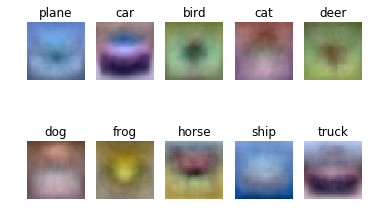

In [15]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])